In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP_jitter, plot_N, TDR_axes, out_axes
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [2]:
model_n = 0
rule = 'fdgo'
which_net = 'l2w0001'
dir_specific_all = 'crystals/softplus/two_tasks/'+which_net+'_fdgo_fdanti'
m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
h_all,trial_all,tasks_all = make_h_trial_rule(m_all,mode = 'test',noise_on = False)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt


In [3]:
m = m_all
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt


In [4]:
def plot_initXtasks(rule_ic_set, rule_in_set, c):
    
    output_labels = ['fixation',r' $\sin{\theta}$',r' $\cos{\theta}$']

    for rule_ic in rule_ic_set['set']:
        t_ind = trial_all[rule_ic].epochs['fix1'][1]-1
        b = 0 #trial number for now
        h0 = h_all[rule_ic][t_ind,b,:]

        for rule_in in rule_in_set['set']:
            t_start = trial_all[rule_in].epochs['fix1'][1]
            t_end = len(trial_all[rule_in].x)
            n_steps = t_end - t_start

            h_t = np.empty((n_steps,n_rnn))
            y_hat = np.empty((n_steps,n_output))
            x_t = trial_all[rule_in].x[range(t_start,t_end),b,:]
            h = h0
            for ti in range(t_end-t_start):
                h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x_t[ti,:]), alpha)
                h_t[ti,:] = h
                y_hat[ti,:] = out_affine(params, h_t[ti,:])

            for out_ind in range(n_output):
                ax = plt.subplot(1,3,out_ind+1)
                plt.plot(y_hat[:,out_ind],c,label = rule_ic + ' ic', alpha = .2,linewidth = 2)
                plt.plot(trial_all[rule_in].y[t_start:t_end,b,out_ind],':'+c,label = rule_in + ' target',linewidth = 2)
                plt.text(0,-.5,output_labels[out_ind])
                plt.ylim((-1.2,1.2))
                
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                if out_ind == 1:
                    plt.title(rule_ic_set['set_name']+' ic, '+ rule_in_set['set_name']+ ' input')
                    plt.legend(('ouput','target'),fontsize = 14)
                else:
                    ax.spines['left'].set_visible(False)
                    ax.spines['bottom'].set_visible(False)
                    ax.get_xaxis().set_ticks([])
                    ax.get_yaxis().set_ticks([])

In [5]:
fdgo_tasks = {'set_name':'DelayPro','set':['fdgo',]}
fdanti_tasks = {'set_name':'DelayAnti','set':['fdanti',]}
delay_tasks = {'set_name':['DelayPro','DelayAnti'],'set':['fdgo','fdanti']}

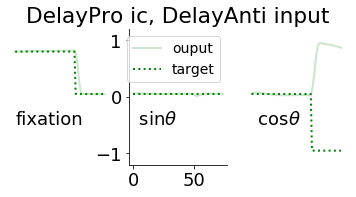

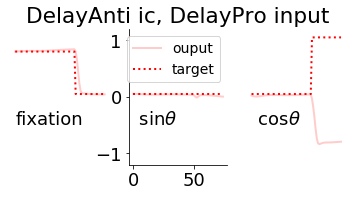

In [6]:
plt.rcParams.update({'font.size': 18})
figpath = os.path.join(p,'code','overleaf','task_schematic_multitask','figs','interp_fps',which_net,str(model_n))
if not os.path.exists(figpath):
    os.makedirs(figpath)

fig = plt.figure(figsize=(6, 2.5))
plot_initXtasks(fdgo_tasks, fdanti_tasks, 'g')
figname = 'fdgoIN_example_output.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(6, 2.5))
plot_initXtasks(fdanti_tasks, fdgo_tasks, 'r')
figname = 'fdantiIN_example_output.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()

In [7]:
def quant_perf(rule_ic_set, rule_in_set):
    for rule_ic in rule_ic_set['set']:
        t_ind = trial_all[rule_ic].epochs['fix1'][1]-1
        
        ri = 0
        for rule_in in rule_in_set['set']:
            t_start = trial_all[rule_in].epochs['fix1'][1]
            t_end = len(trial_all[rule_in].x)
            n_steps = t_end - t_start

            n_trials = trial_all[rule_in].x.shape[1]
            
            y_locs = trial_all[rule_in].y_loc[t_start:,:]
            y_hat = np.empty((n_steps,n_trials,n_output))
            
            for b in range(n_trials):
                h0 = h_all[rule_ic][t_ind,0,:]
                h_t = np.empty((n_steps,n_rnn))
                x_t = trial_all[rule_in].x[range(t_start,t_end),b,:]
                h = h0
                for ti in range(t_end-t_start):
                    h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x_t[ti,:]), alpha)
                    h_t[ti,:] = h
                    y_hat[ti,b,:] = out_affine(params, h_t[ti,:])

            perf = get_perf(y_hat, y_locs)
            plt.plot(ri,np.mean(perf),'ok', alpha = .5)
            ri+=1
            
        plt.xticks(range(len(rule_in_set['set'])), rule_in_set['set'],rotation = 45)
        plt.ylim((-.1,1.1))
        plt.xlim((-.5,ri-.5))
        plt.title(rule_ic + ' ICs')

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt


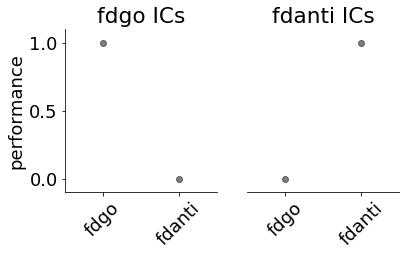

In [8]:
dir_specific_all = 'crystals/softplus/two_tasks/' + which_net + '_fdgo_fdanti'
fig = plt.figure(figsize=(6, 3))

# for model_n_temp in range(5):
model_n_temp = model_n
m_temp = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n_temp))
h_all,trial_all,tasks_all = make_h_trial_rule(m_temp,mode = 'random',noise_on = True)

ax1 = plt.subplot(1,2,1)
quant_perf(fdgo_tasks, delay_tasks)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.ylabel('performance')

ax2 = plt.subplot(1,2,2)
quant_perf(fdanti_tasks, delay_tasks)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])

figname = 'quant_perf.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()

In [ ]:
def make_FP_pcs(f,m_all,rule_in,fp_epoch,n_fps = 5):
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']

    if len(sorted_fps)>2:
        kmeans = KMeans(n_clusters=np.min((n_fps,np.shape(fp_struct['xstar'])[0])), random_state=0).fit(sorted_fps)
        _,fp_inds = np.unique(kmeans.labels_,return_index=True)

        pca = PCA(n_components = 2)
        fp_pca = pca.fit_transform(sorted_fps[fp_inds,:])
        D_use = pca.components_.T
    
    else:
        fp_inds = range(len(sorted_fps))
        D_use = make_axes(m_all,rule_in,fp_epoch)

    return D_use, sorted_fps, fp_inds
    
def plot_N_jitter(m,D_use,rule,fp_epoch,rand_step_coef = 0.01,n_steps = 70,n_jit = 50,
                   lw = 3,al = .6,linestyle = '-',mode = 'test', batch_size = 100):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0

        trial = generate_trials(rule, hparams, mode=mode,noise_on=False, batch_size = 100,delay_fac = 1)
        
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
                                
        if mode=='test':
            trial_set = range(0,S,int(S/8))
        else:
            trial_set = range(0,S,int(S/50))

        for s in trial_set:

            c_inds = trial.y_loc[-1,s]/(2*np.pi)#s/np.max(trial_set)#
            c = cmap(c_inds)

            X_trial = np.dot(h_tf[T_inds,s,:],D_use)
            plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
            plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = lw)
            plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw,markersize = 1)

            x_t = np.matlib.repmat(trial.x[T_inds[1],s,:],n_steps,1)
            for jit in range(n_jit):
                h0 = h_tf[T_inds[0]-1,s,:] + rand_step_coef*npr.randn(N)
                h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
                jitter = np.dot(h_t,D_use)
                plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c,linewidth = .1,alpha = .1)
                plt.plot(jitter[:,0],jitter[:,1],'-',c = c,linewidth = .5,alpha = .5)

def plot_jitter_at_loc(m, rule_ic, rule_in, D_use, epoch, t_num, rand_step_coef = 0, n_steps = 50, n_jit = 50):
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0
        trial = generate_trials(rule_ic, hparams, mode='test', noise_on=False, batch_size = 100,delay_fac = 1)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        
    jit_locs = h_tf[trial.epochs['fix1'][1]-1,:,:]
    loc_inds = np.shape(jit_locs)[0]
    print(loc_inds)
    N = np.shape(h_tf)[2]
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0
        trial = generate_trials(rule_in, hparams, mode='test', noise_on=False, batch_size = 100,delay_fac = 1)
     
    for ii in range(loc_inds):
        
        jit_loc = jit_locs[ii,:]

        T_inds = get_T_inds(trial, epoch)
        x_t = np.matlib.repmat(trial.x[T_inds[1]-1,t_num,:],n_steps,1)
        
        for jit in range(n_jit):
            h0 = jit_loc + rand_step_coef*npr.randn(N)
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use)
            plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = .1,alpha = .1)
            plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = .1)

In [ ]:
task_list = ['fdgo','fdanti']

fig = plt.figure(figsize=(10,5),tight_layout=True,facecolor='white')

fp_epoch = 'stim1'
opp = [1,0]
offset = 0
fp_t_num = [0+offset, 180+offset]
ind_stim_loc = fp_t_num[0]

if ind_stim_loc == 0:
    t_num = 0
else:
    t_num = int(80*ind_stim_loc/360)
    
n_fps = 5

if 'h' in which_net:
    rand_step_coef = 0.0001
else:
    rand_step_coef = 0.1

for ri in range(len(task_list)):
    ax1 = plt.subplot(1,2,ri+1)
#     ax = plt.subplot(1,1,1)
    
    rule_in = task_list[ri]
    rule_ic = task_list[opp[ri]]
    _, rule_in_name, _, _ = take_names(fp_epoch,rule_in)
    epoch_name, rule_ic_name, _, _ = take_names(fp_epoch,rule_ic)
#     D_use = make_axes(m_all,rule_in,fp_epoch)
#     B = generate_Beta_epoch(h_all[rule_in],trial_all[rule_in])
#     D_use = B[fp_epoch]
    
    f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in,fp_epoch+'_'+str(fp_t_num[ri])+'.0.npz')
    D, sorted_fps, fp_inds = make_FP_pcs(f,m_all,rule_in,fp_epoch,n_fps = n_fps)
    
    if rule_in==task_list[0]:
        D, sorted_fps, fp_inds = make_FP_pcs(f,m_all,task_list[0],'stim1',n_fps = n_fps)
        D_use=D
    
    plot_jitter_at_loc(m_all, rule_ic, rule_in, D_use, fp_epoch, t_num, 
                   rand_step_coef = rand_step_coef, n_steps = 50, n_jit = 1)
    plot_N_jitter(m_all,D_use,rule_ic,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = ':')
    plot_N_jitter(m_all,D_use,rule_in,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = '-')
    
    plot_FP_jitter(m_all,D_use,rule_in,t_num,fp_epoch,sorted_fps,fp_inds,[rule_in,],
               rand_step_coef = rand_step_coef, linestyle ='-', n_steps = 100, n_jit = 20)
    
    tit = rule_in_name + ' IN, ' + rule_ic_name + ' IC'
    plt.title(tit)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.xlabel('Fixed Pts PC1')
    plt.ylabel('Fixed Pts PC2')
    
figname = 'PCS_'+task_list[0]+'_'+task_list[1]+fp_epoch+str(fp_t_num[0])+'_'+tit+'.pdf'
plt.savefig(os.path.join(figpath,figname))
plt.show()

stim1
stim1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
80
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring param

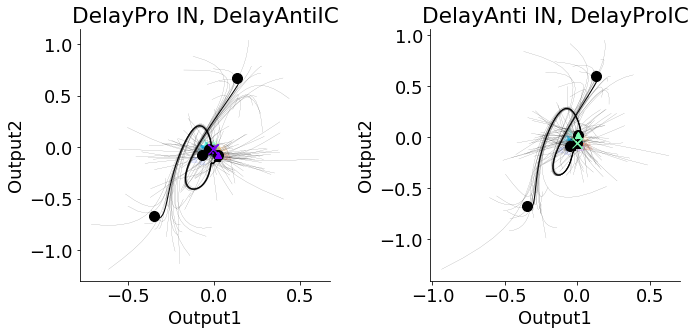

In [11]:
fig = plt.figure(figsize=(10,5),tight_layout=True,facecolor='white')

for ri in range(len(task_list)):
    ax1 = plt.subplot(1,2,ri+1)
    
    rule_in = task_list[ri]
    rule_ic = task_list[opp[ri]]
    _, rule_in_name, _, _ = take_names(fp_epoch,rule_in)
    epoch_name, rule_ic_name, _, _ = take_names(fp_epoch,rule_ic)
    
    f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in,fp_epoch+'_'+str(fp_t_num[ri])+'.0.npz')
    _, sorted_fps, fp_inds = make_FP_pcs(f,m_all,rule_in,fp_epoch,n_fps = n_fps)
    
    D_use = w_out[:,1:]
    
    plot_jitter_at_loc(m_all, rule_ic, rule_in, D_use, fp_epoch, t_num, 
                   rand_step_coef = rand_step_coef, n_steps = 50, n_jit = 1)
    plot_N_jitter(m_all,D_use,rule_ic,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = ':')
    plot_N_jitter(m_all,D_use,rule_in,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = '-')
    
    plot_FP_jitter(m_all,D_use,rule_in,t_num,fp_epoch,sorted_fps,fp_inds,[rule_in,],
               rand_step_coef = rand_step_coef, linestyle ='-', n_steps = 100, n_jit = 20)
    
    tit = rule_in_name + ' IN, ' + rule_ic_name + 'IC'
    plt.title(tit)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.xlabel('Output1')
    plt.ylabel('Output2')
    
figname = 'Out_'+task_list[0]+'_'+task_list[1]+'stim'+str(fp_t_num[0])+'_'+tit+'.pdf'
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [12]:
def make_X_steps_task(m, step_file, epoch, task_list, n_fps_init, t_num = 0, n_interp = 20):
    
    trial = gen_trials_from_model_dir(m,task_list[0],noise_on = False)
    _,x1 = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    inds_use = [int(x) for x in np.linspace(T_inds[1],x1.shape[2]-1,n_interp)]
    h_tf = x1[:,:,inds_use]
    fp_steps = []

    for step_i in range(n_interp):
        n_fps = n_fps_init

        filename = task_list[0]+'_'+task_list[1]+'_trial_'+str(t_num)+'_step_'+str(step_i)
        filename = os.path.join(m,step_file,epoch,task_list[0]+'_'+task_list[1],filename+'.npz')
        fp_struct = np.load(filename)

        sorted_fps = fp_struct['xstar']
        if np.shape(sorted_fps)[0]>n_fps:
            kmeans = KMeans(n_clusters=n_fps, random_state=0).fit(sorted_fps)
            _,fp_inds = np.unique(kmeans.labels_,return_index=True)
        else: 
            fp_inds = range(np.shape(sorted_fps)[0])

        n_fps = len(fp_inds)
        dst_FP = np.zeros((n_fps))
        for s in range(n_fps):
            dst_FP[s] = LA.norm(h_tf[:,t,step_i] - sorted_fps[fp_inds[s],:])

        sorted_inds = [fp_inds[int(x)] for x in np.argsort(dst_FP)]
        fps_sorted = sorted_fps[sorted_inds,:]

        if fp_steps == []:
            fp_steps = fps_sorted
            num_found = [np.shape(fps_sorted)[0],]
            qstar_vals = fp_struct['qstar'][sorted_inds]
        else:
            fp_steps = np.concatenate((fp_steps, fps_sorted), axis=0)
            num_found = num_found+ [np.shape(fps_sorted)[0],]
            qstar_vals = np.concatenate((qstar_vals,fp_struct['qstar'][sorted_inds]))
            
    X = np.squeeze(fp_steps).astype(np.float64)
    D = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    dst = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
        for yi in range(np.shape(X)[0]):
            D[xi,yi] = LA.norm(X[xi,:]-X[yi,:])
            dst[xi,yi] = distance.euclidean(X[xi,:], X[yi,:])

    embedding = MDS(n_components = 2,dissimilarity = 'precomputed')
    X_steps = embedding.fit_transform(dst)
    
    return X_steps,dst,fp_steps,num_found,qstar_vals,X

In [13]:
def plot_h_mds_steps(X_transformed,n_interp,nfps,dot_alpha = .3):
    cmap=plt.get_cmap('plasma')
        
    for ri in range(n_interp):
        c = cmap(ri/n_interp)
        X_trial = X_transformed[(ri*nfps):((ri+1)*nfps),:]
        plt.plot(X_trial[:,0],X_trial[:,1],'o',c = c,alpha = dot_alpha,markersize = 10)

        
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    return

def plot_h_mds_steps_qstar(X_transformed,qstar_vals,size=200,dot_alpha = .3):
    
    cmap=plt.get_cmap('jet')
    plt.scatter(X_transformed[:,0],X_transformed[:,1],size,-np.log10(qstar_vals),alpha = dot_alpha,cmap='jet')

        
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    return

In [14]:
t = 0
t_num = t
epoch_set = ['stim1','go1']
epoch = epoch_set[0]
rule = task_list[0]
n_interp = 20
n_fps_init = 60
# step_file ='fp_stepXtasks_fwd_stim_big_init'
step_file ='fixed_pts_stepX_tasks_fwd_mov'
# step_file ='fixed_pts_stepX_tasks_fwd_large_init'

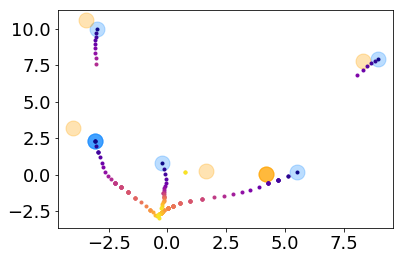

In [15]:
task_list = ['fdgo','fdanti']
fp_t_num = [0,180]
fp_epoch = 'stim1'

f = os.path.join(m,'tf_fixed_pts_all_init',task_list[0],fp_epoch+'_'+str(fp_t_num[0])+'.0.npz')
D_use, sorted_fps, fp_inds = make_FP_pcs(f,m_all,task_list[0],fp_epoch,n_fps = n_fps)

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['dodgerblue','orange']
for ti in range(len(task_list)):
    task = task_list[ti]
    f = os.path.join(m,'tf_fixed_pts_all_init',task,fp_epoch+'_'+str(fp_t_num[ti])+'.0.npz')
    _, sorted_fps, fp_inds = make_FP_pcs(f,m_all,rule_in,fp_epoch,n_fps = n_fps)
    fp_project = np.dot(sorted_fps,D_use)
    plt.plot(fp_project[:,0],fp_project[:,1],'o',c = cmap_discrete[ti],markersize = 15, alpha = .3)

for step_i in range(20):
    f = task_list[0]+'_'+task_list[1]+'_trial_'+str(t_num)+'_step_'+str(step_i)
    filename = os.path.join(m,step_file,epoch,task_list[0]+'_'+task_list[1],f+'.npz')
    fp_struct = np.load(filename)
    step_fps = fp_struct['xstar']
    
    fp_project = np.dot(step_fps,D_use)
    plt.plot(fp_project[:,0],fp_project[:,1],'.',c = cmap_grad(step_i/20))

In [16]:
t_num = 0
epoch = 'stim1'
n_fps_init = 5
X_steps,D,fp_steps,num_found,qstar_vals,X = make_X_steps_task(m_all, step_file, epoch, task_list, n_fps_init, t_num = t_num, n_interp = 20)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Use

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


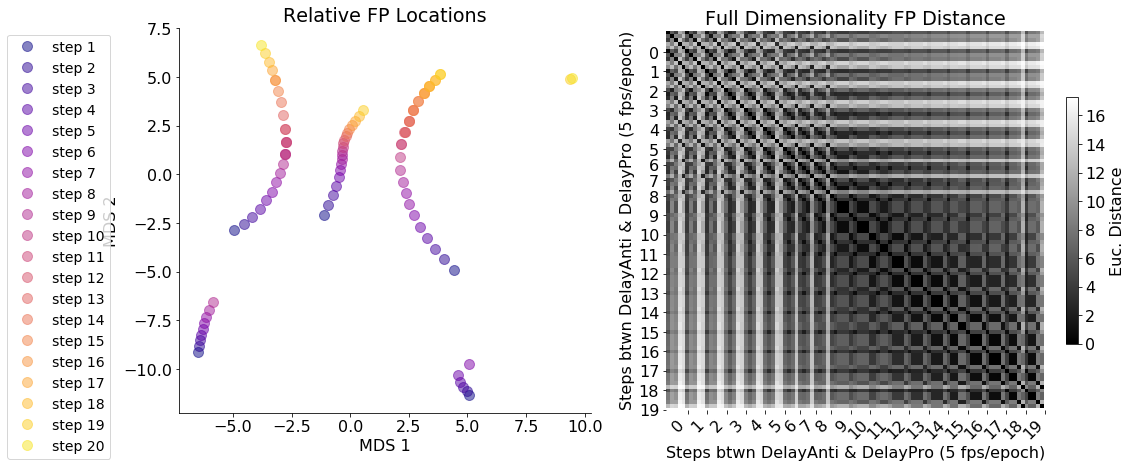

In [18]:
n_fps = n_fps_init
new_names = [str(step_i) for step_i in range(n_interp)]

fig = plt.figure(figsize=(16,6.8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

ax1 = plt.subplot(1,2,1)
plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
legend_set = ['step '+ str(x) for x in range(1,21)]
plt.legend((legend_set),bbox_to_anchor=(-.15, 1),fontsize = 14)
plt.title('Relative FP Locations')

ax2 = plt.subplot(1,2,2)
# n_trials_each = 100
plt.imshow(D,'gray')
tick_locs = num_found#range(int(n_fps/2),n_fps*n_interp,n_fps)
plt.xticks(np.cumsum(num_found),range(len(num_found)),rotation = 45, ha="right", va="top")
plt.yticks(np.cumsum(num_found),range(len(num_found)))
plt.xlabel('Steps btwn ' + rule_in_name + ' & ' + rule_ic_name + ' ('+str(n_fps)+' fps/epoch)')
plt.ylabel('Steps btwn ' + rule_in_name + ' & ' + rule_ic_name + ' ('+str(n_fps)+' fps/epoch)')

cbar = plt.colorbar(fraction = .03)
cbar.set_label('Euc. Distance')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
plt.title('Full Dimensionality FP Distance')

figname = task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_colored_by_step.pdf'
if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
plt.savefig(os.path.join(figpath,step_file,figname))

plt.show()

In [19]:
def plot_indep_fps(m,D,rule,fp_epoch,trial,c,add_zero = True):
    cmap=plt.get_cmap('plasma')
    
    if add_zero is True:
        filename = os.path.join(m,'tf_fixed_pts_all_init',rule,fp_epoch+'_'+str(trial)+'.0.npz')
    else:
        filename = os.path.join(m,'golub_fixed_pts',rule,fp_epoch+'_'+str(trial)+'.npz')

    print(filename)
    fp_struct = np.load(filename)
    fps = fp_struct['xstar']
    qs = fp_struct['qstar']

    X_steps = np.dot(fps,D)
    if isinstance(c, str):
        plt.scatter(X_steps[:,0],X_steps[:,1],150,c,edgecolors='k')
    else:
        plt.scatter(X_steps[:,0],X_steps[:,1],150,cmap(c*1000),edgecolors='k')
    return

In [20]:
def plot_steps_tasks(m, task_nums, X, qstar_vals, n_interp, n_fps, t_num = 0,  
                     plotN = False, plotN_epoch = 'delay1', plotIFPs = False, add_zero = True):

    task_list = [rules_dict['all'][task_nums[0]], rules_dict['all'][task_nums[1]]]
    trial_set = range(0,80,10)
    t_num_list = [0,180]
    
    D1 = make_axes(m,task_list[0],plotN_epoch,ind = -1)
    D2 = D1#make_axes(m,task_list[1],plotN_epoch,ind = -1)
    f = os.path.join(m,'tf_fixed_pts_all_init','fdanti','stim1'+'_'+str(180)+'.0.npz')
    D_fp, sorted_fps, fp_inds = make_FP_pcs(f,m_all,task_list[0],plotN_epoch,n_fps = n_fps)
    D = D_fp
    w_in, b_in, w_out, b_out = get_model_params(m)
    D_go = w_out[:,1:]
    
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(2,2,1)
    X_steps = np.dot(X,D)
    
    
    if plotN:
        for sp in [1,3]:
            
            ax = plt.subplot(2,2,sp)
            
            trial1 = gen_trials_from_model_dir(m,task_list[0],noise_on = False)
            _,x = gen_X_from_model_dir(m,trial1)
            T_inds = get_T_inds(trial1,plotN_epoch)
            x1 = np.transpose(x[:,:,T_inds],(1,2,0))
            plot_N(x1[trial_set,:,:],D.T,trial1.y_loc[-1,trial_set])

            trial2 = same_stim_trial(trial1, task_nums[1])
            _,x = gen_X_from_model_dir(m,trial2)
            T_inds = get_T_inds(trial2,plotN_epoch)
            x2 = np.transpose(x[:,:,T_inds],(1,2,0))
            plot_N(x2[trial_set,:,:],D.T,trial2.y_loc[-1,trial_set])
            
            if plotIFPs:
                for task_num in range(2):
                    
                    if sp==3:
                        c = 'k'
                        plot_h_mds_steps_qstar(X_steps,qstar_vals,size = 30)
                    else:
                        c = task_num
                        plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5)
                        
                    plot_indep_fps(m,D,task_list[task_num],plotN_epoch,t_num_list[task_num],c,add_zero = add_zero)
            
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.xlabel('FP PC1',fontsize = 20)
            plt.ylabel('FP PC1',fontsize = 20)
    
    ax2 = plt.subplot(2,2,2)
    X_steps = np.dot(X,D_go)
    plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5)
    if plotN:
        plot_N(x1[trial_set,:,:],D_go.T,trial1.y_loc[-1,trial_set])
    out_axes(ax2)
    legend_set = ['step '+ str(x) for x in range(1,21)]
    plt.legend((legend_set),bbox_to_anchor=(1.5, 1),fontsize = 11.9)

    ax4 = plt.subplot(2,2,4)
    X_steps = np.dot(X,D_go)
    plot_h_mds_steps_qstar(X_steps,qstar_vals,size = 30)
#     if plotN:
#         plot_N(x1[trial_set,:,:],D_go.T,trial1.y_loc[-1,trial_set])
    out_axes(ax4)
    axins = inset_axes(ax4,
                   width="5%",  # width = 5% of parent_bbox width
                   height="60%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.2, -1.2, 1, .7),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )

    cbar = plt.colorbar(cax = axins)
    cbar.set_label('-log10(qstar)',rotation = 90)
    return

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
either


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Use

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/tf_fixed_pts_all_init/fdanti/stim1_180.0.npz


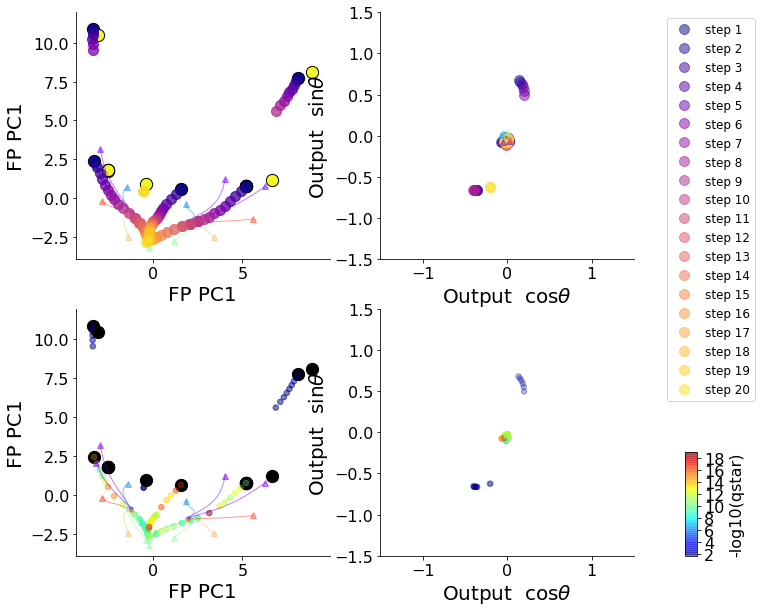

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
X = np.squeeze(fp_steps).astype(np.float64)
plot_steps_tasks(m,[0,3],X,qstar_vals,n_interp,n_fps,plotN = True, plotN_epoch = 'stim1',
                plotIFPs = True, add_zero = True)
figname = task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_fp_activity_overlay.pdf'
plt.savefig(os.path.join(figpath,step_file,figname))
plt.show()

In [22]:
def plot_steps_tasks(m, task_nums, X, qstar_vals, n_interp, n_fps, t_num = 0,  
                     plotN = False, plotN_epoch = 'delay1', plotIFPs = False, add_zero = True):

    task_list = [rules_dict['all'][task_nums[0]], rules_dict['all'][task_nums[1]]]
    trial_set = range(0,80,10)
    t_num_list = [0,180]
    dot_alpha = .8
    marker_size = 100
    legend_set = ['step '+ str(x) for x in range(1,21)]
    
    D1 = make_axes(m,task_list[0],plotN_epoch,ind = -1)
    D2 = D1#make_axes(m,task_list[1],plotN_epoch,ind = -1)
    f = os.path.join(m,'tf_fixed_pts_all_init','fdanti','stim1'+'_'+str(180)+'.0.npz')
    D_fp, sorted_fps, fp_inds = make_FP_pcs(f,m_all,task_list[0],plotN_epoch,n_fps = n_fps)
    D = D_fp
    w_in, b_in, w_out, b_out = get_model_params(m)
    D_go = w_out[:,1:]

    X_steps = np.dot(X,D)
    if plotN:
        for sp in [1,3]:
            
            fig = plt.figure(figsize=(4+sp/2, 5))
            ax = plt.subplot(1,1,1)
            
            if plotIFPs:
                for task_num in range(2):
                    
                    if sp==3:
                        c = 'k'
                        plot_h_mds_steps_qstar(X_steps,qstar_vals,dot_alpha = dot_alpha,size = marker_size)
                        if task_num==0:
                            cbar = plt.colorbar()
                            cbar.set_label('-log10(qstar)',rotation = 90)
                    else:
                        c = task_num
                        plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = dot_alpha)
                        plt.legend((legend_set),bbox_to_anchor=(1.01, 1),fontsize = 11)
                        
                    plot_indep_fps(m,D,task_list[task_num],plotN_epoch,t_num_list[task_num],c,add_zero = add_zero)
            
            trial1 = gen_trials_from_model_dir(m,task_list[0],noise_on = False)
            _,x = gen_X_from_model_dir(m,trial1)
            T_inds = get_T_inds(trial1,plotN_epoch)
            x1 = np.transpose(x[:,:,T_inds],(1,2,0))
            plot_N(x1[trial_set,:,:],D.T,trial1.y_loc[-1,trial_set])

            trial2 = same_stim_trial(trial1, task_nums[1])
            _,x = gen_X_from_model_dir(m,trial2)
            T_inds = get_T_inds(trial2,plotN_epoch)
            x2 = np.transpose(x[:,:,T_inds],(1,2,0))
            plot_N(x2[trial_set,:,:],D.T,trial2.y_loc[-1,trial_set])
            
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.xlabel('FP PC1',fontsize = 20)
            plt.ylabel('FP PC1',fontsize = 20)
            
            if sp==3:
                figname = 'step_color_fpPC_'+task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_fp_activity_overlay.pdf'
            else:
                figname = 'q_color_fpPC_'+task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_fp_activity_overlay.pdf'
            
            plt.savefig(os.path.join(figpath,step_file,figname), bbox_inches = 'tight')
            plt.show()
    
    fig = plt.figure(figsize=(5, 5))
    x = plt.subplot(1,1,1)
    X_steps = np.dot(X,D_go)
    plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = dot_alpha)
    if plotN:
        plot_N(x1[trial_set,:,:],D_go.T,trial1.y_loc[-1,trial_set])
    out_axes(ax)
    
    plt.legend((legend_set),bbox_to_anchor=(1.01, 1),fontsize = 11)
    figname = 'q_color_out_'+task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_fp_activity_overlay.pdf' 
    plt.savefig(os.path.join(figpath,step_file,figname), bbox_inches = 'tight')
    plt.show()

    fig = plt.figure(figsize=(5.5, 5))
    ax = plt.subplot(1,1,1)
    X_steps = np.dot(X,D_go)
    plot_h_mds_steps_qstar(X_steps,qstar_vals,dot_alpha = dot_alpha,size = marker_size)
#     if plotN:
#         plot_N(x1[trial_set,:,:],D_go.T,trial1.y_loc[-1,trial_set])
    out_axes(ax)

    cbar = plt.colorbar()#cax = axins)
    cbar.set_label('-log10(qstar)',rotation = 90)
    figname = 'q_color_out_'+task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_fp_activity_overlay.pdf' 
    plt.savefig(os.path.join(figpath,step_file,figname), bbox_inches = 'tight')
    plt.show()
    return

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
either
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters fr

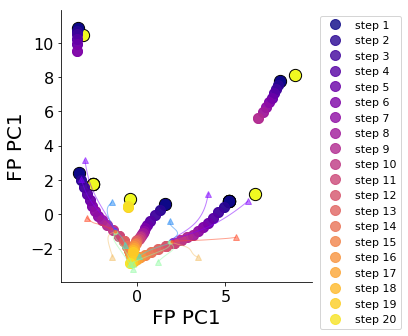

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/tf_fixed_pts_all_init/fdanti/stim1_180.0.npz
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky

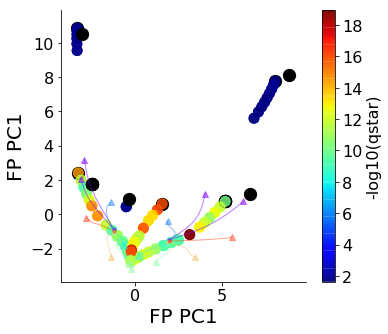

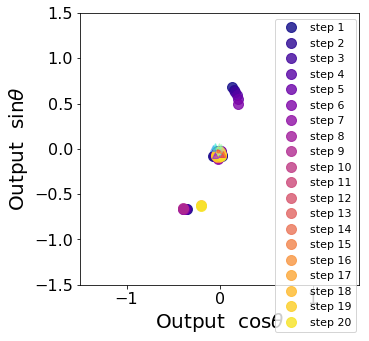

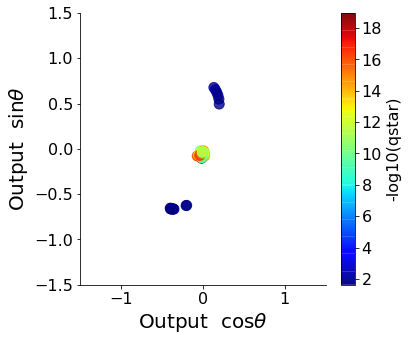

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
X = np.squeeze(fp_steps).astype(np.float64)
plot_steps_tasks(m,[0,3],X,qstar_vals,n_interp,n_fps,plotN = True, plotN_epoch = 'stim1',
                plotIFPs = True, add_zero = True)